# The Emotions of the Presidential Candidates
There is currently tons of pressure on each presidential candidate. We will use IBM Watson's Tone Analyzer in order to learn more about how their emotions have changed over the past four months, based on their tweets (which we acquire using the Twitter-Python library) and the things they said in the debates.



## Python-Twitter Library
Twitter provides REST APIs to access their data. Python-Twitter is a wrapper library that makes utilizing Twitter's REST calls very easy. Twitter requires you to register with them as a developer in order to get access keys. This is free!

After registering through Twitter's website, I used the following python-twitter tutorial to authenticate and use the library.
https://python-twitter.readthedocs.io/en/latest/getting_started.html


I wrote a very small script called load_credentials so that I can access both the Watson and Twitter APIs without keeping my credentials in this notebook. To run on your own, you should easily be able to duplicate their functionality.

In [1]:
import twitter
import load_credentials

twitter = load_credentials.get_api()
# twitter.VerifyCredentials()

Let's pull the candidates tweets from the past four or five months. This is made easy with the 'timeline' feature of the API.

In [2]:
import time
trump_id = 788803222496346112 
# I hard-coded the most recent tweet in so that I can have some consistency in building/running this.
# if you want the most recent version, uncomment the following line
# trump_id = twitter.GetUserTimeline(screen_name='realDonaldTrump',count=1)[0].id

trump_all_tweets = []
for i in range(16):
    trump_timeline = twitter.GetUserTimeline(screen_name='realDonaldTrump',count=200,max_id=trump_id)
    time.sleep(1)
    trump_all_tweets.extend(trump_timeline)
    trump_id=trump_timeline[-1].id # we update the max_id according to the Twitter API's layout in order
    # to access all tweets from a timeline. See Twitter's documentation for more info on why this is needed

In [3]:
clinton_id = 788906579156463617
# clinton_id = twitter.GetUserTimeline(screen_name='HillaryClinton',count=1)[0].id

clinton_all_tweets = []
for i in range(16):
    clinton_timeline = twitter.GetUserTimeline(screen_name='HillaryClinton',count=200,max_id=clinton_id)
    time.sleep(1)
    clinton_all_tweets.extend(clinton_timeline)
    clinton_id=clinton_timeline[-1].id

Let's take a quick look to see how often that candidates retweet vs write their own tweets

In [4]:
clinton_tweets = [x for x in clinton_all_tweets if x.retweeted_status is None]
clinton_with_retweets = len(clinton_all_tweets)
clinton_authored = len(clinton_tweets)
print "Clinton has retweeted " + str(clinton_with_retweets - clinton_authored) + " tweets and tweeted " + \
    str(clinton_authored) + " original tweets."

trump_tweets = [x for x in trump_all_tweets if x.retweeted_status is None]
trump_with_retweets = len(trump_all_tweets)
trump_authored = len(trump_tweets)
print "Trump has retweeted " + str(trump_with_retweets - trump_authored) + " tweets and tweeted " + \
    str(trump_authored) + " original tweets."

Clinton has retweeted 664 tweets and tweeted 2331 original tweets.
Trump has retweeted 155 tweets and tweeted 2892 original tweets.


At this point, we can disregard the retweets, as they won't tell us directly about the candidate's tone.

## Grouping into  Time Periods and Cleaning
Let's group our tweets into three different time periods, that way we can see potential changes in tone as the election season has progressed. The initial data we have from Clinton starts on June 9th, so we will begin our analysis there. To determine the exact days to split our data, we will script out some quick timediff ideas. 
Then, we can partition our tweets by date.

In [5]:
from datetime import date, datetime
from dateutil import parser

today = date(date.today().year, 10, 25) # lock in date, to use current date, uncomment line below
# today = date.today()
start = date(today.year, 6, 9) # June 9
end = date(today.year, today.month, today.day)
diff = (end - start) / 3 # get the diff, then find the length of a portion of it

for i in range(4):
    print (start + i*diff)

split_1 = (start + 1*diff)
split_2 = (start + 2*diff)

def group_tweets(tweets):
    grouped_tweets = [[],[],[]] # this will contain three lists of tweets, grouped by date
    for tweet in tweets:
        date = parser.parse(tweet.created_at).date()
        if date <= split_1 and date >= start:
            grouped_tweets[0].append(tweet.text.encode('utf-8', 'ignore'))
        elif date <= split_2 and date >= start:
            grouped_tweets[1].append(tweet.text.encode('utf-8', 'ignore'))
        elif date >= start:
            grouped_tweets[2].append(tweet.text.encode('utf-8', 'ignore'))
    return grouped_tweets

clinton_grouped_tweets = group_tweets(clinton_tweets)
trump_grouped_tweets = group_tweets(trump_tweets)

2016-06-09
2016-07-25
2016-09-09
2016-10-25


We will need to further clean up the tweets. Let's remove all hyperlinks and transform hashtags from '\#oneLongString' to 'one long string'. 

In [6]:
import re

def remove_link(str):
    return re.sub(r"http\S+", "", str)

def expand_hashtag(tweet_list):
    cleaned_list = [] # return a new list, rather than update in-place
    for i in range(len(tweet_list)):
        str = tweet_list[i]
        cleaned = ""
        hash = False
        for i in range(len(str)):
            if str[i] == '#':
                hash = True
            elif str[i] == ' ':
                hash = False
                cleaned += str[i]
            elif not hash:
                cleaned += str[i]
            else:
                if str[i].isupper():
                    if str[i-1] != '#':
                        cleaned += ' '
                    cleaned += str[i]
                else:
                    cleaned += str[i]
        cleaned_list.append(remove_link(cleaned))
    return cleaned_list

for i in range(3):
    clinton_grouped_tweets[i] = expand_hashtag(clinton_grouped_tweets[i])
    trump_grouped_tweets[i] = expand_hashtag(trump_grouped_tweets[i])

For the last step in our cleaning process, let's merge each of our groups of tweets into a string so that we can send them off to Watson.

In [7]:
clinton_tweets = [[],[],[]]
trump_tweets = [[],[],[]]

for i in range(3):
    clinton_tweets[i] = ''.join(clinton_grouped_tweets[i])
    trump_tweets[i] = ''.join(trump_grouped_tweets[i])

## Tone Analyzer
In order to use the Tone Analyzer, you must first set up a (free) account with Bluemix, IBM's online platform. The free account is limited to 1000 API calls per month. In your account, you can get an API key for the Tone Analyzer.
To install, load credentials, and run a hello world equivalent, I used the following tutorial:
https://www.ibm.com/watson/developercloud/tone-analyzer/api/v3/?python#authentication

In [8]:
import load_credentials
import json

tone_analyzer = load_credentials.get_tone_analyzer()

clinton_scores = [[],[],[]]
trump_scores = [[],[],[]]

for i in range(3):
    clinton_scores[i] = tone_analyzer.tone(text=clinton_tweets[i])
    trump_scores[i] = tone_analyzer.tone(text=trump_tweets[i])
    with open('clinton_scores'+str(i)+'.json', 'w') as outfile:
        json.dump(clinton_scores[i], outfile)
    with open('trump_scores'+str(i)+'.json', 'w') as outfile:
        json.dump(trump_scores[i], outfile)

## Understanding the JSON Result
Watson will give us back a JSON for every string that we sent it. Each of the JSONs will have its fields scored with a value between 0 and 1. The higher the value, the more prevalent that tone is in the text. Watson scores the following properties:

1) Emotional Tone. This is meant to describe the emotions the author may have been feeling. The five emotions analyzed are joy, fear, sadness, disgust, and anger. 

2) Social Tone. This measures five common social tendencies in writing, namely openness, conscientiousness, extraversion, agreeableness, and emotional range.

3) Language Tone. This measures the writing style into three categories: analytic, confident, and tentative.

In addition, the JSON will include a sentence-by-sentence analysis. We won't use this.

In [9]:
#print clinton_scores[0]['document_tone']['tone_categories'][0]['tones'][0]['score'] # anger
#print clinton_scores[0]['document_tone']['tone_categories'][0]['tones'][1]['score'] # disgust
import json

clinton_scores = [[],[],[]]
trump_scores = [[],[],[]]
for i in range(3):
    with open ('clinton_scores'+str(i)+'.json', 'r') as file:
        clinton_scores[i] = json.load(file)
    with open ('trump_scores' + str(i) + '.json', 'r') as file:
        trump_scores[i] = json.load(file)

# quick method to parse the lengthy JSON and give the the data we want (the score)
def get_score(score_list, tone_index,category_id): # index is the score based on JSON. Example: Anger is 0, Disgust is 2
    ys = []      # category_id is the category, as seen in the JSON and documentation
    for score in score_list:
        emotional_tone = score['document_tone']['tone_categories'][category_id]['tones']
        ys.append(emotional_tone[tone_index]['score'])
    return ys

We can now use matplotlib to graph the results!

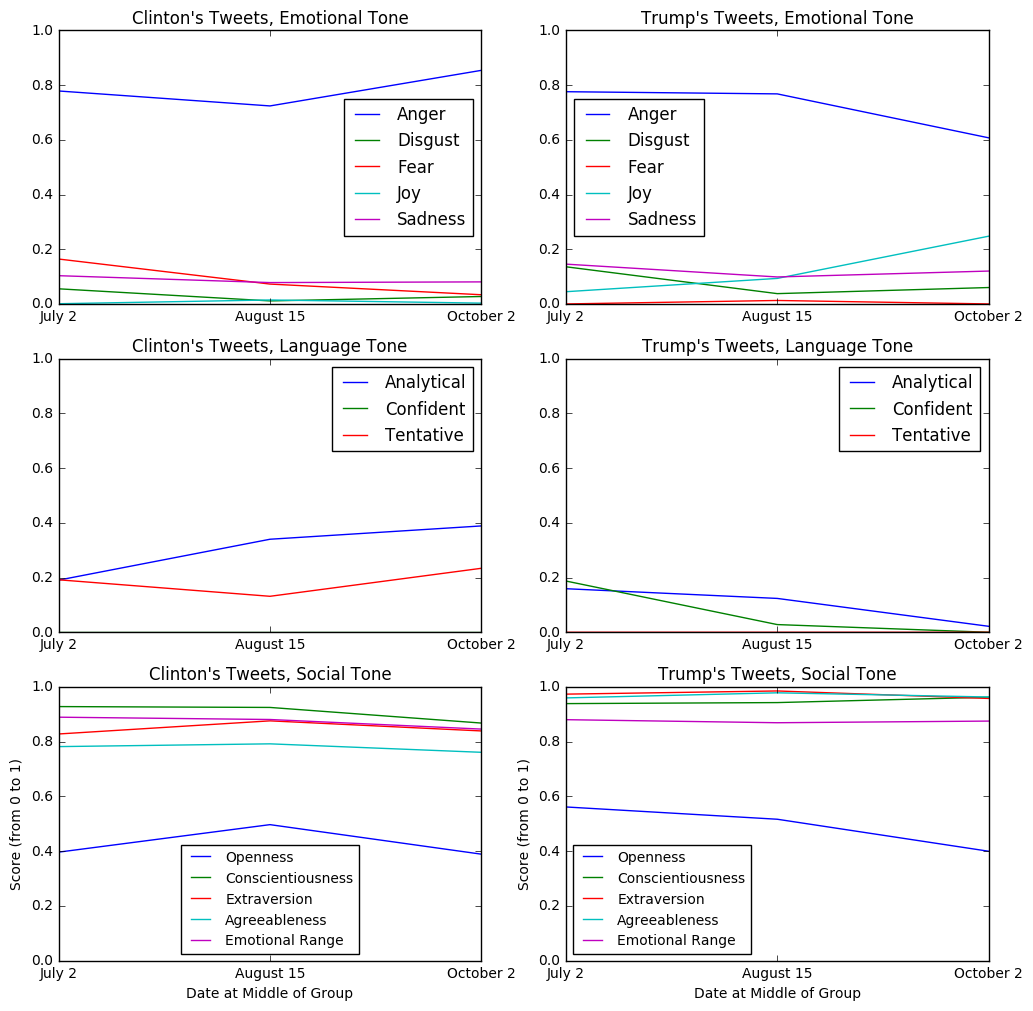

In [10]:
import matplotlib.pyplot as plt
import numpy as np

f, ((c1,t1),(c2,t2),(c3,t3)) = plt.subplots(3,2)
f.set_size_inches(12,12)

x_dates = ['July 2', 'August 15', 'October 2'] # the middle date in each time period
plt.setp(((c1,t1),(c2,t2),(c3,t3)), xticks=[0,1,2], xticklabels=x_dates)

# Clinton's Tweets
x = np.array([0,1,2])
c1.plot(x, get_score(clinton_scores,0,0), label='Anger')
c1.plot(x, get_score(clinton_scores,1,0), label='Disgust')
c1.plot(x, get_score(clinton_scores,2,0), label='Fear')
c1.plot(x, get_score(clinton_scores,3,0), label='Joy')
c1.plot(x, get_score(clinton_scores,4,0), label='Sadness')
c1.set_title("Clinton's Tweets, Emotional Tone")
x1, x2, y1, y2 = c1.axis()
c1.axis((x1,x2,0,1))
c1.legend(loc='best')

c2.plot(x, get_score(clinton_scores,0,1), label='Analytical')
c2.plot(x, get_score(clinton_scores,1,1), label='Confident')
c2.plot(x, get_score(clinton_scores,2,1), label='Tentative')
c2.legend(loc='best')
x1, x2, y1, y2 = c2.axis()
c2.axis((x1,x2,0,1))
c2.set_title("Clinton's Tweets, Language Tone")

c3.plot(x, get_score(clinton_scores,0,2), label='Openness')
c3.plot(x, get_score(clinton_scores,1,2), label='Conscientiousness')
c3.plot(x, get_score(clinton_scores,2,2), label='Extraversion')
c3.plot(x, get_score(clinton_scores,3,2), label='Agreeableness')
c3.plot(x, get_score(clinton_scores,4,2), label='Emotional Range')
c3.set_ylabel('Score (from 0 to 1)')
c3.legend(loc='best',prop={'size':10})
c3.set_xlabel('Date at Middle of Group')
x1, x2, y1, y2 = c3.axis()
c3.axis((x1,x2,0,1))
c3.set_title("Clinton's Tweets, Social Tone")

# trump's tweets
x = np.array([0,1,2])
t1.plot(x, get_score(trump_scores,0,0), label='Anger')
t1.plot(x, get_score(trump_scores,1,0), label='Disgust')
t1.plot(x, get_score(trump_scores,2,0), label='Fear')
t1.plot(x, get_score(trump_scores,3,0), label='Joy')
t1.plot(x, get_score(trump_scores,4,0), label='Sadness')
t1.set_title("Trump's Tweets, Emotional Tone")
t1.legend(loc='best')
x1, x2, y1, y2 = t1.axis()
t1.axis((x1,x2,0,1))

t2.plot(x, get_score(trump_scores,0,1), label='Analytical')
t2.plot(x, get_score(trump_scores,1,1), label='Confident')
t2.plot(x, get_score(trump_scores,2,1), label='Tentative')
t2.legend(loc='best')
x1, x2, y1, y2 = t2.axis()
t2.axis((x1,x2,0,1))
t2.set_title("Trump's Tweets, Language Tone")

t3.plot(x, get_score(trump_scores,0,2), label='Openness')
t3.plot(x, get_score(trump_scores,1,2), label='Conscientiousness')
t3.plot(x, get_score(trump_scores,2,2), label='Extraversion')
t3.plot(x, get_score(trump_scores,3,2), label='Agreeableness')
t3.plot(x, get_score(trump_scores,4,2), label='Emotional Range')
t3.set_ylabel('Score (from 0 to 1)')
t3.legend(loc='best',prop={'size':10})
t3.set_xlabel('Date at Middle of Group')
x1, x2, y1, y2 = t3.axis()
t3.axis((x1,x2,0,1))
t3.set_title("Trump's Tweets, Social Tone")

plt.show()

## Twitter Conclusions
After seeing the graphs that we made, we can pretty easily see that the candidates are primarily angry....
To read more about what each result indicates, visit https://www.ibm.com/watson/developercloud/doc/tone-analyzer/understanding-tone.shtml

Notably, Watson seems to show that they have relatively low levels of 'openness', which is defined in the documentation as "More likely to be perceived as no-nonsense, straightforward, blunt, or preferring tradition and the obvious over the complex, ambiguous, and subtle." This is reasonable, since tweest have to be short and to the point.

Additionally, neither candidate seems to be very analytical, which the documentation describes as "A person's reasoning and analytical attitude about things."

Watson returned 0 for Clinton's Confidence score, and 0 for Trump's Tentative score.

Candidates (and their social media teams) could use this information to adjusts tweets before posting them so as to send a more positive message to the country.

## Analyzing The Debates
To add to our understanding of the candidates, we can examine their debates. We can look at the transcripts from all three debates, which are available online. We can send each of these off to Watson to see how they stacked up.

The transcripts are available online, I simply downloaded them to text files, parsed them up, and sent each candidate's respective parts off to Watson!

In [ ]:
def extract_text(debate):
    clinton_txt = ""
    trump_txt = ""
    trump = False
    clinton = False

    i = 0
    while (i < len(debate)): # boolean logic to put text into appropriate speaker's string
        if debate[i] == '\n': # new speakers only begin on new lines
            if debate[i+1:i+6].lower() == 'trump':
                trump = True
                clinton = False
                i += 6
            elif debate[i+1:i+8].lower() == 'clinton':
                trump = False
                clinton = True
                i += 8
            else: # moderator
                trump = False
                clinton = False
        else: # append to appropriate speaker's string
            if trump:
                trump_txt += debate[i]
            if clinton:
                clinton_txt += debate[i]
        i += 1
    return clinton_txt, trump_txt

with open('first-debate.txt', 'r') as file:
    debate1 = file.read()
with open('second-debate.txt', 'r') as file:
    debate2 = file.read()
with open('third-debate.txt', 'r') as file:
    debate3 = file.read()

clinton_1, trump_1 = extract_text(debate1)
clinton_2, trump_2 = extract_text(debate2)
clinton_3, trump_3 = extract_text(debate3)
clinton_deb = [clinton_1, clinton_2, clinton_3]
trump_deb = [trump_1, trump_2, trump_3]

Now to send the text off to Watson

In [ ]:
import load_credentials
import json

tone_analyzer = load_credentials.get_tone_analyzer()

clinton_1_score = tone_analyzer.tone(text=clinton_1)
clinton_2_score = tone_analyzer.tone(text=clinton_2)
clinton_3_score = tone_analyzer.tone(text=clinton_3)
trump_1_score = tone_analyzer.tone(text=trump_1)
trump_2_score = tone_analyzer.tone(text=trump_2)
trump_3_score = tone_analyzer.tone(text=trump_3)

The following is another quick way to extract the data we want from the lengthy JSONs

In [ ]:
def get_debate_score(clinton, tone_index, category_id): # same index as previous get_score, clinton is bool to choose between candidates
    ys = []
    if clinton:
        ys.append(clinton_1_score['document_tone']['tone_categories'][category_id]['tones'][tone_index]['score'])
        ys.append(clinton_2_score['document_tone']['tone_categories'][category_id]['tones'][tone_index]['score'])
        ys.append(clinton_3_score['document_tone']['tone_categories'][category_id]['tones'][tone_index]['score'])
    else:
        ys.append(trump_1_score['document_tone']['tone_categories'][category_id]['tones'][tone_index]['score'])
        ys.append(trump_2_score['document_tone']['tone_categories'][category_id]['tones'][tone_index]['score'])
        ys.append(trump_3_score['document_tone']['tone_categories'][category_id]['tones'][tone_index]['score'])
    return ys

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Clinton's Debates
x = np.array([0,1,2])
f, ((c1,t1),(c2,t2),(c3,t3)) = plt.subplots(3,2)
f.set_size_inches(12,12)

plt.setp(((c1,t1),(c2,t2),(c3,t3)), xticks=[0,1,2], xticklabels=['1st Debate', '2nd Debate', '3rd Debate'])

c1.plot(x, get_debate_score(True,0,0), label='Anger')
c1.plot(x, get_debate_score(True,1,0), label='Disgust')
c1.plot(x, get_debate_score(True,2,0), label='Fear')
c1.plot(x, get_debate_score(True,3,0), label='Joy')
c1.plot(x, get_debate_score(True,4,0), label='Sadness')
c1.set_title("Clinton's Debates, Emotional Tone")
c1.legend(loc='best')
x1, x2, y1, y2 = c1.axis()
c1.axis((x1,x2,0,1))

c2.plot(x, get_debate_score(True,0,1), label='Analytical')
c2.plot(x, get_debate_score(True,1,1), label='Confident')
c2.plot(x, get_debate_score(True,2,1), label='Tentative')
c2.legend(loc='best')
x1, x2, y1, y2 = c2.axis()
c2.axis((x1,x2,0,1))
c2.set_title("Clinton's Debates, Language Tone")

c3.set_xticks(x, ['1st Debate', '2nd Debate', '3rd Debate'])
c3.plot(x, get_debate_score(True,0,2), label='Openness')
c3.plot(x, get_debate_score(True,1,2), label='Conscientiousness')
c3.plot(x, get_debate_score(True,2,2), label='Extraversion')
c3.plot(x, get_debate_score(True,3,2), label='Agreeableness')
c3.plot(x, get_debate_score(True,4,2), label='Emotional Range')
c3.set_ylabel('Score (from 0 to 1)')
c3.legend(loc='best',prop={'size':10})
x1, x2, y1, y2 = c3.axis()
c3.axis((x1,x2,0,1))
c3.set_title("Clinton's Debates, Social Tone")

# Trump's Debates
t1.plot(x, get_debate_score(False,0,0), label='Anger')
t1.plot(x, get_debate_score(False,1,0), label='Disgust')
t1.plot(x, get_debate_score(False,2,0), label='Fear')
t1.plot(x, get_debate_score(False,3,0), label='Joy')
t1.plot(x, get_debate_score(False,4,0), label='Sadness')
t1.set_title("Trump's Debates, Emotional Tone")
t1.legend(loc='best')
x1, x2, y1, y2 = t1.axis()
t1.axis((x1,x2,0,1))

t2.plot(x, get_debate_score(False,0,1), label='Analytical')
t2.plot(x, get_debate_score(False,1,1), label='Confident')
t2.plot(x, get_debate_score(False,2,1), label='Tentative')
t2.legend(loc='best')
x1, x2, y1, y2 = t2.axis()
t2.axis((x1,x2,0,1))
t2.set_title("Trump's Debates, Language Tone")

t3.plot(x, get_debate_score(False,0,2), label='Openness')
t3.plot(x, get_debate_score(False,1,2), label='Conscientiousness')
t3.plot(x, get_debate_score(False,2,2), label='Extraversion')
t3.plot(x, get_debate_score(False,3,2), label='Agreeableness')
t3.plot(x, get_debate_score(False,4,2), label='Emotional Range')
t3.set_ylabel('Score (from 0 to 1)')
t3.legend(loc='best',prop={'size':10})
x1, x2, y1, y2 = t3.axis()
t3.axis((x1,x2,0,1))
t3.set_title("Trump's Debates, Social Tone")

plt.show()

# Conclusion
In the debates as well as on their tweets, the candidates' primary emotional tone was anger. The variance that this had between the past several months and between the three different debates seems negligible - so we can assume they have had the same level of anger for quite some time now. 

They were both more analytical during the debates than they were during tweets. This makes sense - a debate is (supposed to be) a time to analyze the pros and cons of each side's plans and ideas.

Surprisingly, they both scored relatively high on 'agreeableness', with Trump scoring it as his most prominent social tone in each of his debates. Watson defines this feature as being "more likely to be perceived as caring, sympathetic, cooperative, compromising, trustworthy, or humble". Perhaps the tone analyzer saw that he was trying to be sympathetic towards the voter groups he was targeting.

Overall, the Tone Analyzer provided results that seem to be in line with expectations.